# Model-1 (LSTM, fbProphet, Daily Close Price)

## Import Libraries

In [153]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
from scipy.stats import kstest
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.pipeline import Pipeline
from matplotlib.pylab import rcParams
from fastai.tabular import add_datepart
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

rcParams['figure.figsize'] = 18, 12

## Import Dataset

In [154]:
data = pd.read_csv("Crude_All.csv")
df = data.copy()

## Exploratory Data Analysis

### Initial Dataset Shape

In [155]:
print(f"Shape of Data: {df.shape[0]} Rows, {df.shape[1]} Columns")

Shape of Data: 5317 Rows, 7 Columns


### Head and Tail of the Data

In [156]:
print("Head Values of Data:")
print(df.head())
print("\nTail Values of Data:")
print(df.tail())

Head Values of Data:
         Date       Open       High        Low      Close  Adj Close   Volume
0  2000-08-23  31.950001  32.799999  31.950001  32.049999  32.049999  79385.0
1  2000-08-24  31.900000  32.240002  31.400000  31.629999  31.629999  72978.0
2  2000-08-25  31.700001  32.099998  31.320000  32.049999  32.049999  44601.0
3  2000-08-28  32.040001  32.919998  31.860001  32.869999  32.869999  46770.0
4  2000-08-29  32.820000  33.029999  32.560001  32.720001  32.720001  49131.0

Tail Values of Data:
            Date       Open       High  ...      Close  Adj Close    Volume
5312  2021-07-02  75.019997  75.620003  ...  75.160004  75.160004  377531.0
5313  2021-07-06  75.349998  76.980003  ...  73.370003  73.370003  714044.0
5314  2021-07-07  73.849998  74.860001  ...  72.199997  72.199997  607971.0
5315  2021-07-08  72.169998  73.260002  ...  72.940002  72.940002  529690.0
5316  2021-07-09  73.260002  74.760002  ...  74.559998  74.559998  529690.0

[5 rows x 7 columns]


### Check Variables and Data types

In [157]:
print("Info about DataFrame:\n")
df.info()

Info about DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5317 entries, 0 to 5316
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5317 non-null   object 
 1   Open       5210 non-null   float64
 2   High       5210 non-null   float64
 3   Low        5210 non-null   float64
 4   Close      5210 non-null   float64
 5   Adj Close  5210 non-null   float64
 6   Volume     5210 non-null   float64
dtypes: float64(6), object(1)
memory usage: 290.9+ KB


### Check NULL/NA/NAN Values Row Count



In [158]:
print(f"Columns with NULL/NA/NAN Values:\n{df.isnull().any()}\n")
print(f"Number of rows with NULL/NA/NAN Values: {df.isnull().any(axis=1).sum()}")

Columns with NULL/NA/NAN Values:
Date         False
Open          True
High          True
Low           True
Close         True
Adj Close     True
Volume        True
dtype: bool

Number of rows with NULL/NA/NAN Values: 107


### Feature Engineering

In [159]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [160]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

In [161]:
add_datepart(df, 'Date', drop=False)
df.drop('Elapsed', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [162]:
df.head()

,Date,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2000-08-23,32.049999,2000,8,34,23,2,236,False,False,False,False,False,False
1,2000-08-24,31.629999,2000,8,34,24,3,237,False,False,False,False,False,False
2,2000-08-25,32.049999,2000,8,34,25,4,238,False,False,False,False,False,False
3,2000-08-28,32.869999,2000,8,35,28,0,241,False,False,False,False,False,False
4,2000-08-29,32.720001,2000,8,35,29,1,242,False,False,False,False,False,False


### Convert Date to DateTime Index

In [163]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.asfreq('D')

### Plot Close Data

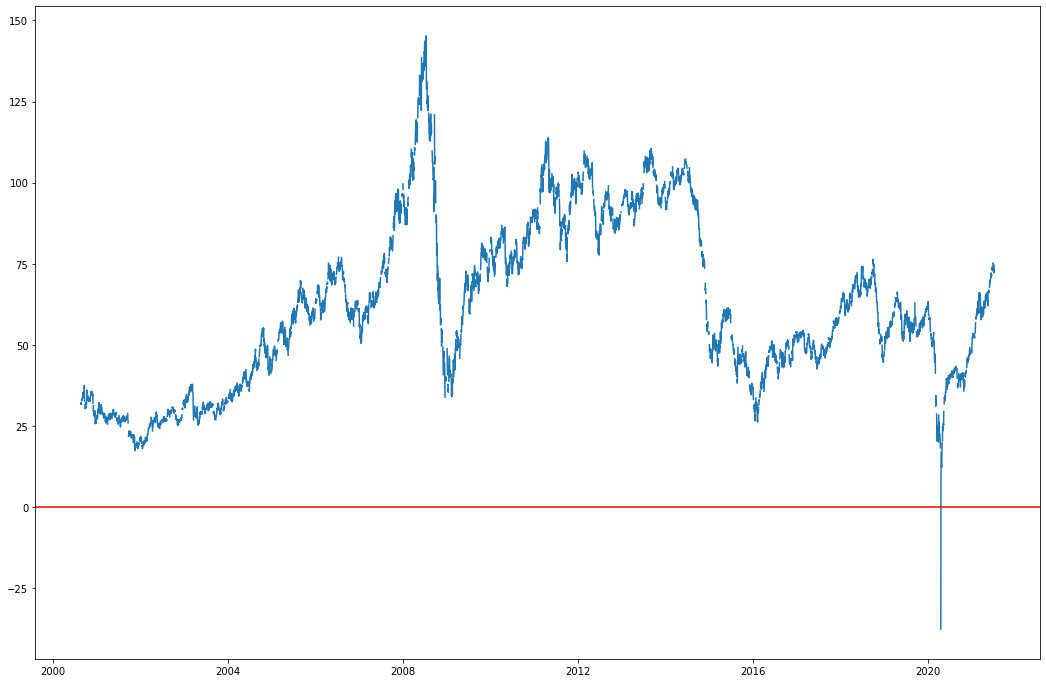

In [164]:
plt.plot(df.Close)
plt.axhline(y=0, c='r')

### Drop rows with NULL/NA/NAN Values

In [165]:
df = df.dropna(axis=0)

### Drop rows with Close <= 0

In [166]:
df = df[~(df['Close'] <= 0)]

### Plotting Yearly Trends

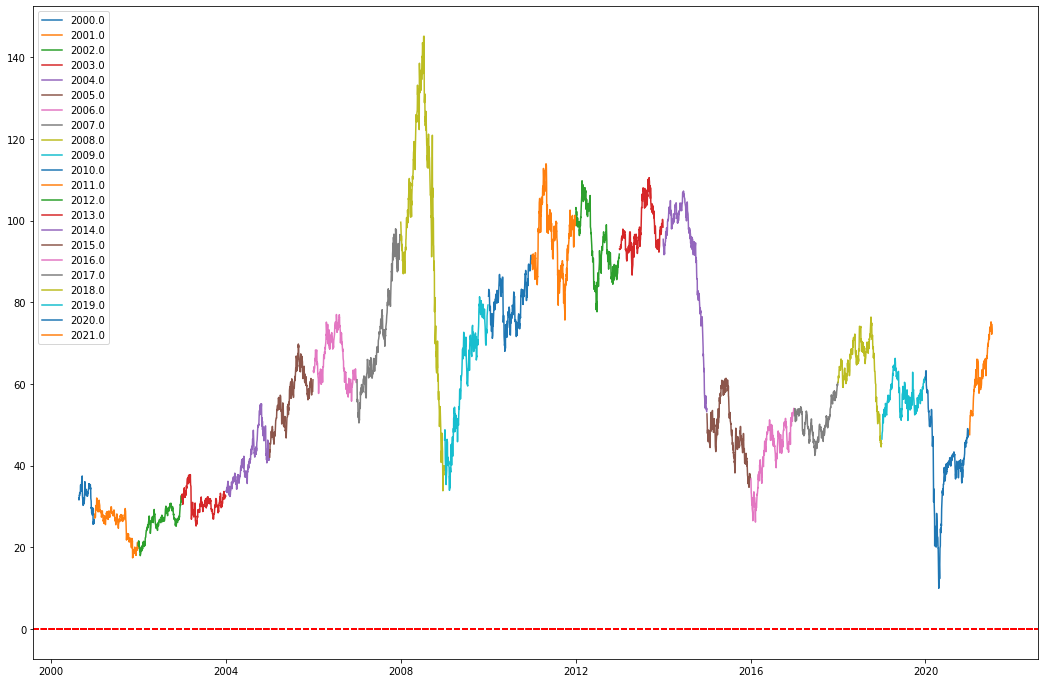

In [167]:
for year in df['Year'].unique():
    close_data = pd.DataFrame()
    close_data['Year_Close'] = df.loc[df.Year == year].Close.values
    close_data['Month'] = df.loc[df.Year == year].Month.values
    close_data['Date'] = df.loc[df.Year == year].index.values
    plt.plot(close_data.Date, close_data.Year_Close, label=year)
    plt.legend()
    plt.axhline(y=0, c='r', ls='--')

### Plotting Monthly Trends

In [168]:
monthly_avgs = {
    1.: [],
    2.: [],
    3.: [],
    4.: [],
    5.: [],
    6.: [],
    7.: [],
    8.: [],
    9.: [],
    10.: [],
    11.: [],
    12.: []
}

for yr in df.Year.unique():
    for mn in df.loc[(df.Year == yr)].Month.unique():
        monthly_avgs[mn].extend(df.loc[(df.Year == yr) & (df.Month == mn)].Close.values)

for mn in df.loc[(df.Year == 2001.)].Month.unique():
    monthly_avgs[mn] = np.mean(monthly_avgs[mn])

([<matplotlib.axis.XTick at 0x7fd5b2e9f650>,
 [Text(0, 0, 'Jan'),
  Text(0, 0, 'Feb'),
  Text(0, 0, 'Mar'),
  Text(0, 0, 'Apr'),
  Text(0, 0, 'May'),
  Text(0, 0, 'Jun'),
  Text(0, 0, 'Jul'),
  Text(0, 0, 'Aug'),
  Text(0, 0, 'Sep'),
  Text(0, 0, 'Oct'),
  Text(0, 0, 'Nov'),
  Text(0, 0, 'Dec')])

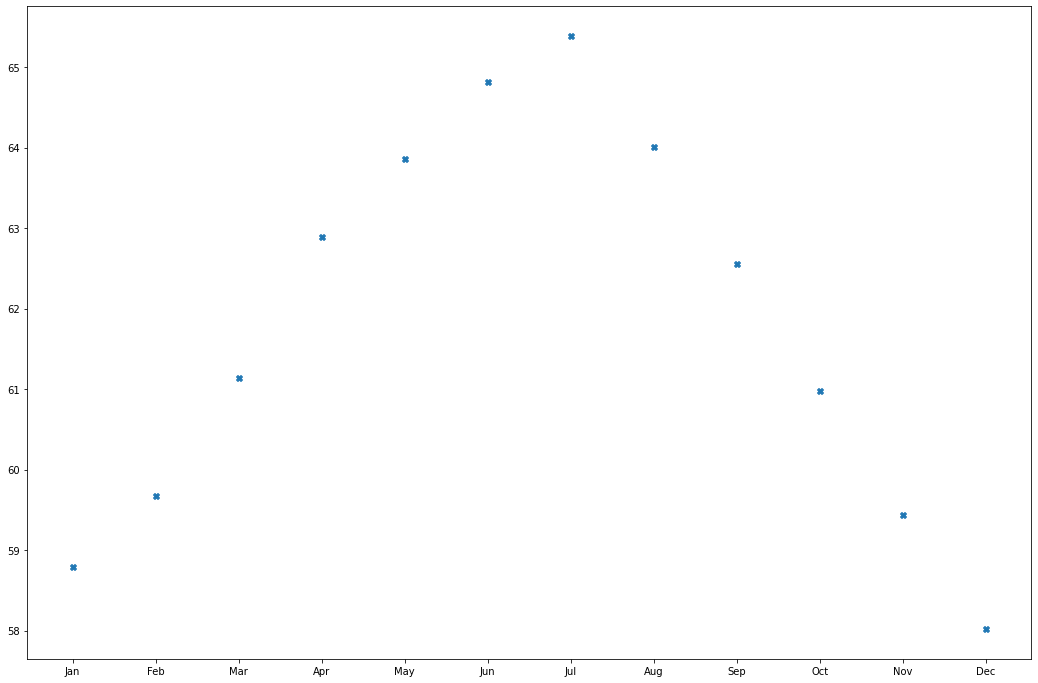

In [169]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.scatter(x=range(1,13), y=monthly_avgs.values(), marker='X')
plt.xticks(ticks=range(1,13), labels=months)

## Working out Outliers in Data

In [170]:
df = data.copy()
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df = df.dropna(axis=0)
df = df[~(df['Close'] <= 0)]

### Adding Simple Return Column
Simple Return = (Present NAV - Starting NAV) / (Starting NAV)<br>
NAV - Net Asset Value

In [171]:
df['SimpleReturn'] = df['Close'].pct_change()

### Calculate Mean and Standard Deviation as the boundary

In [172]:
aggSR = df['SimpleReturn'].agg(['mean', 'std'])

### Plot Simple Return Histogram

Text(0.5, 1.0, 'Simple Return Histogram')

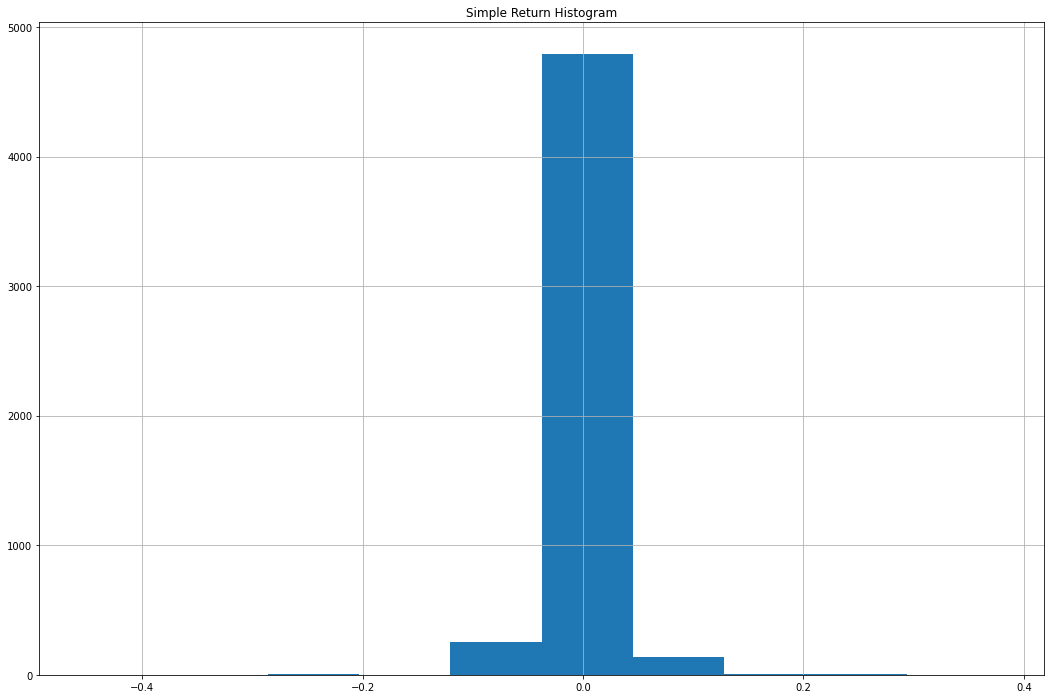

In [173]:
df['SimpleReturn'].hist()
plt.title('Simple Return Histogram')

### Kolmogorov-Smirnov test

In [174]:
SRdata = df.SimpleReturn[1:]

In [175]:
kstest(SRdata, 'norm')

KstestResult(statistic=0.4640897864179445, pvalue=0.0)

### Plot Mean and Standard Deviation Line
Using 3 times the standard deviation as The Empirical Rule states that 99.7% of data observed following a normal distribution lies within 3 standard deviations of the mean.

Text(0.5, 1.0, 'Mean and 3*Standard Deviation of Data')

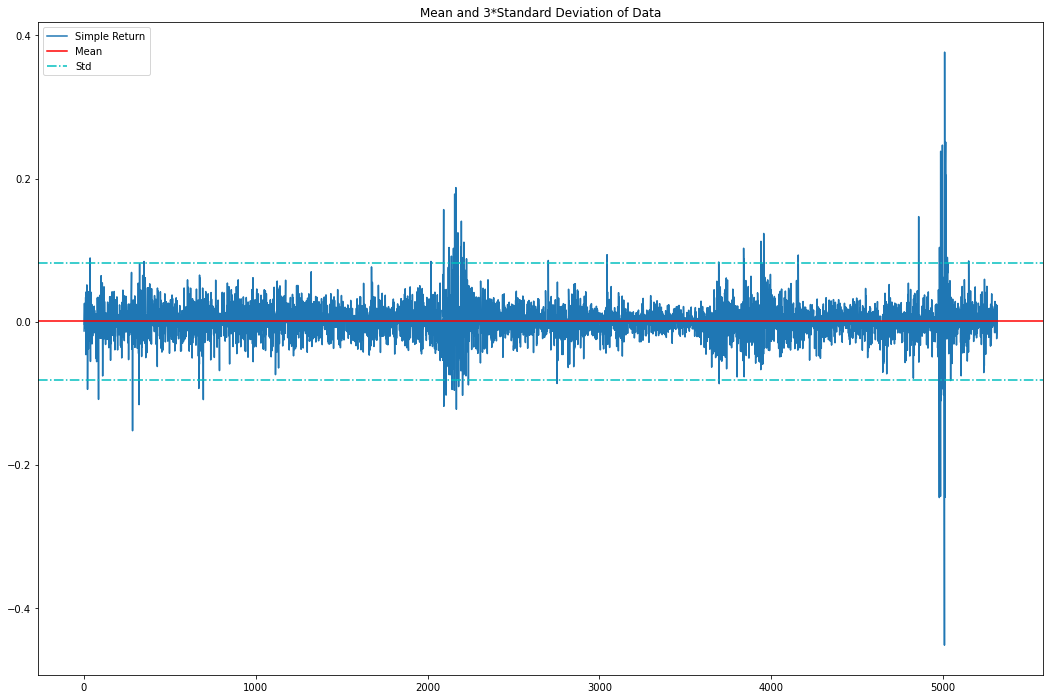

In [176]:
fig, ax = plt.subplots(figsize=(18,12))
df['SimpleReturn'].plot(label='Simple Return', legend=True, ax = ax)
plt.axhline(y=aggSR.loc['mean'], c='r', label='Mean')
plt.axhline(y=3*aggSR.loc['std'], c='c', linestyle='-.',label='Std')
plt.axhline(y=-3*aggSR.loc['std'], c='c', linestyle='-.')
plt.legend(loc='upper left')
plt.title('Mean and 3*Standard Deviation of Data')

### Extract Outliers

In [177]:
mu = aggSR.loc['mean']
sigma = aggSR.loc['std']
thresh = (df['SimpleReturn'] > mu + sigma * 3) | (df['SimpleReturn'] < mu - sigma * 3)
df['Outlier'] = np.where(thresh, 1, 0)
print(f"Number of Outliers found: {df.Outlier.value_counts()}")

Number of Outliers found: 0    5143
1      66
Name: Outlier, dtype: int64


### Plot the Outliers

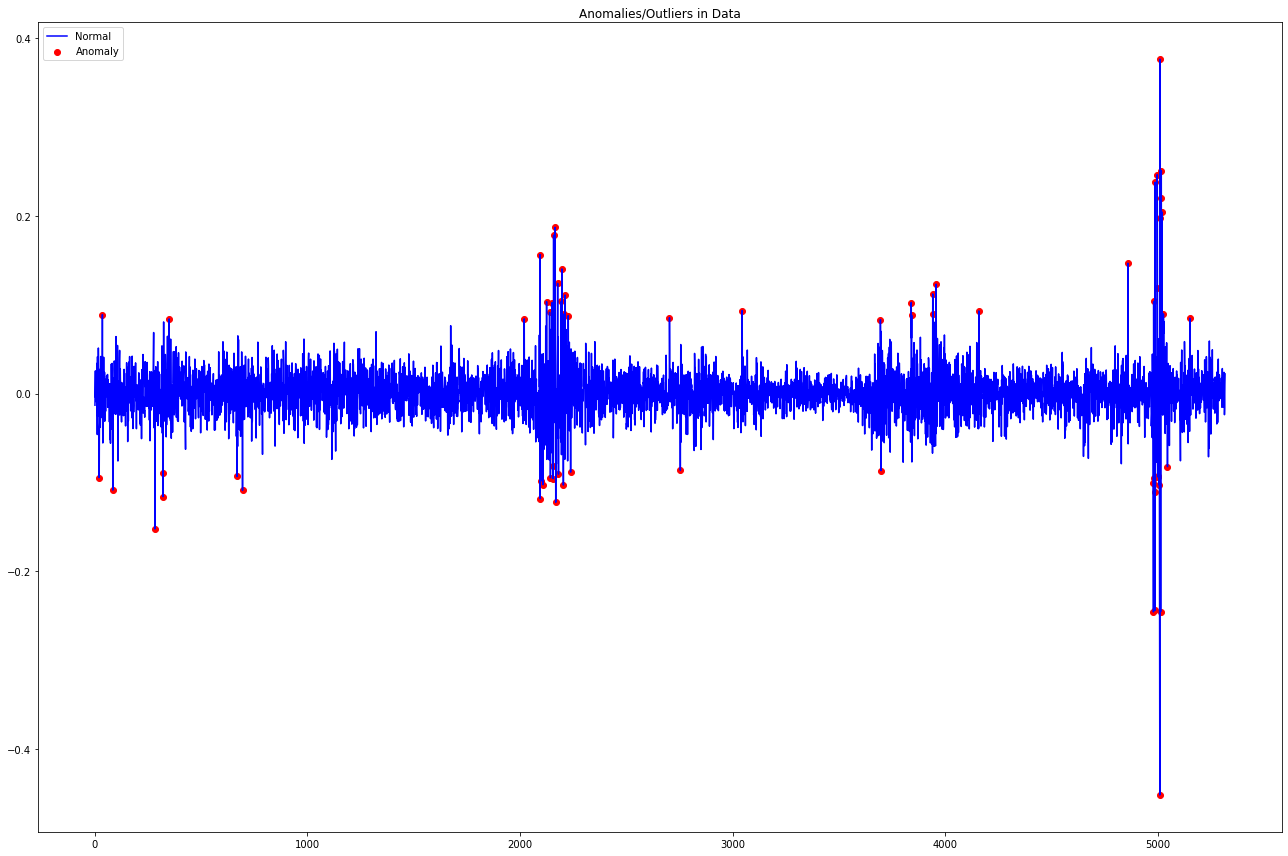

In [178]:
outliers = df.loc[df['Outlier'] == 1, ['SimpleReturn']]
fig, ax = plt.subplots(figsize=(18,12))
ax.plot(df.index, df['SimpleReturn'], color='blue', label='Normal')
ax.scatter(outliers.index, outliers['SimpleReturn'], color='red', label='Anomaly')
ax.legend(loc='upper left')
plt.title('Anomalies/Outliers in Data')
plt.tight_layout()
plt.show()

### Removing Outliers from Data

In [179]:
df = df[~(df["Outlier"] == 1)]

### Plot Mean and Standard Deviation Line after removing Outliers
Using 3 times the standard deviation 

Text(0.5, 1.0, 'Data with no Outliers')

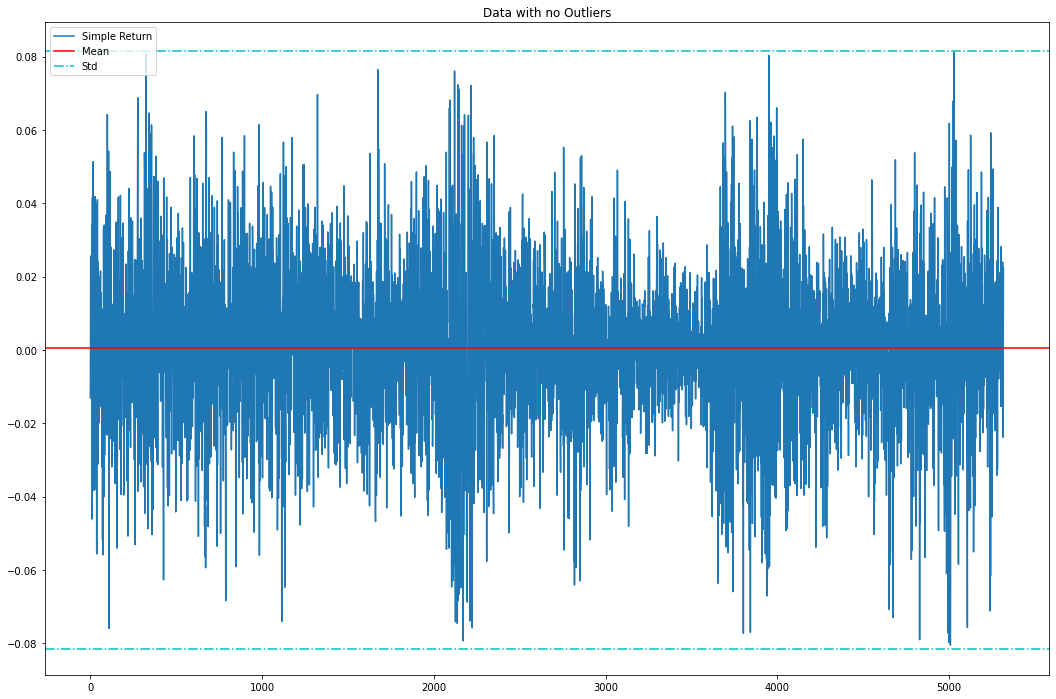

In [180]:
fig, ax = plt.subplots(figsize=(18,12))
df['SimpleReturn'].plot(label='Simple Return', legend=True, ax = ax)
plt.axhline(y=aggSR.loc['mean'], c='r', label='Mean')
plt.axhline(y=3*aggSR.loc['std'], c='c', linestyle='-.',label='Std')
plt.axhline(y=-3*aggSR.loc['std'], c='c', linestyle='-.')
plt.legend(loc='upper left')
plt.title("Data with no Outliers")

## Predicting Close Price using LSTM Model

In [181]:
df = data.copy()
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.asfreq('D')
df = df.dropna(axis=0)
df = df[~(df['Close'] <= 0)]

### Plot Close Price History

Text(0.5, 1.0, 'Close Price History')

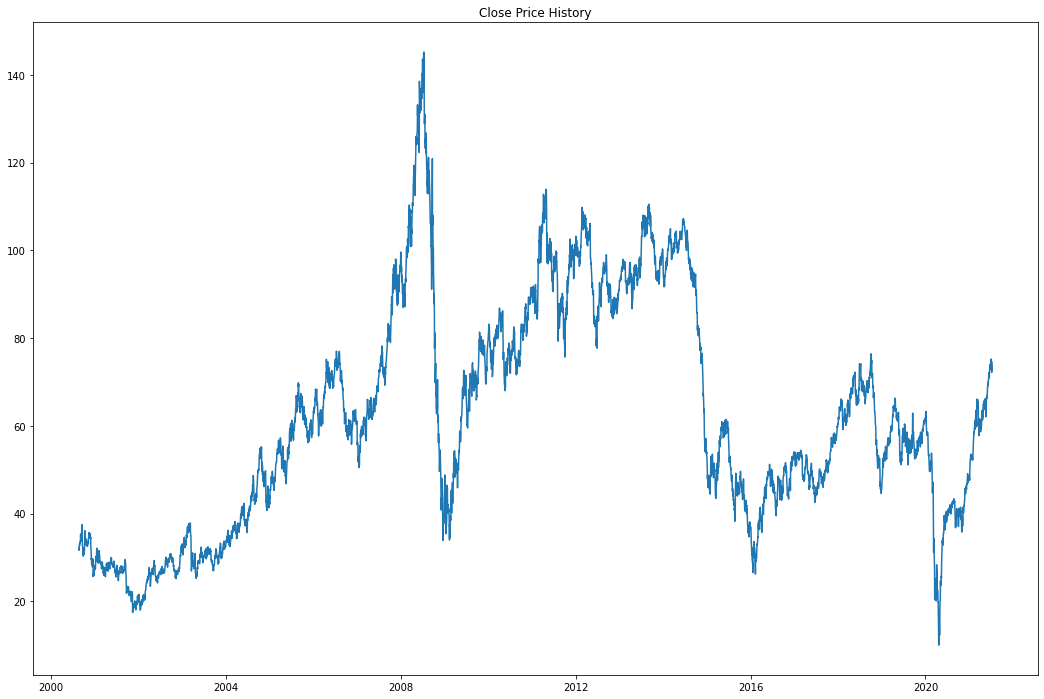

In [182]:
fig, ax = plt.subplots(figsize=(18,12))
plt.plot(df['Close'])
plt.title('Close Price History')

### Perform Long Short Term Memory (LSTM) on the Data

In [183]:
df_data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
dates = pd.to_datetime(df_data.index).strftime('%Y.%m.%d')
for i in range(0,len(df_data)):
    new_dataset["Date"][i]=dates[i]
    new_dataset["Close"][i]=df_data["Close"][i]

In [184]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values

train_data=final_dataset[0:3500,:]
valid_data=final_dataset[3500:5000,:]
test_data=final_dataset[5000:,:]

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(new_dataset)

x_train_data,y_train_data=[],[]

for i in range(90,len(train_data)):
    x_train_data.append(scaled_data[i-90:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [185]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-299:5000].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=1)

3410/3410 [==============================] - 120s 34ms/step - loss: 0.0038


In [186]:
X_test=[]
for i in range(90,inputs_data.shape[0]):
    X_test.append(inputs_data[i-90:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [187]:
lstm_model.save("saved_model.h5")

In [188]:
train_data=new_dataset[0:3500]
valid_data=new_dataset[3500:5000]
valid_data['Predictions']=predicted_closing_price

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Plot Actual and Predicted Values



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

Text(0.5, 1.0, 'Close Price Prediction')

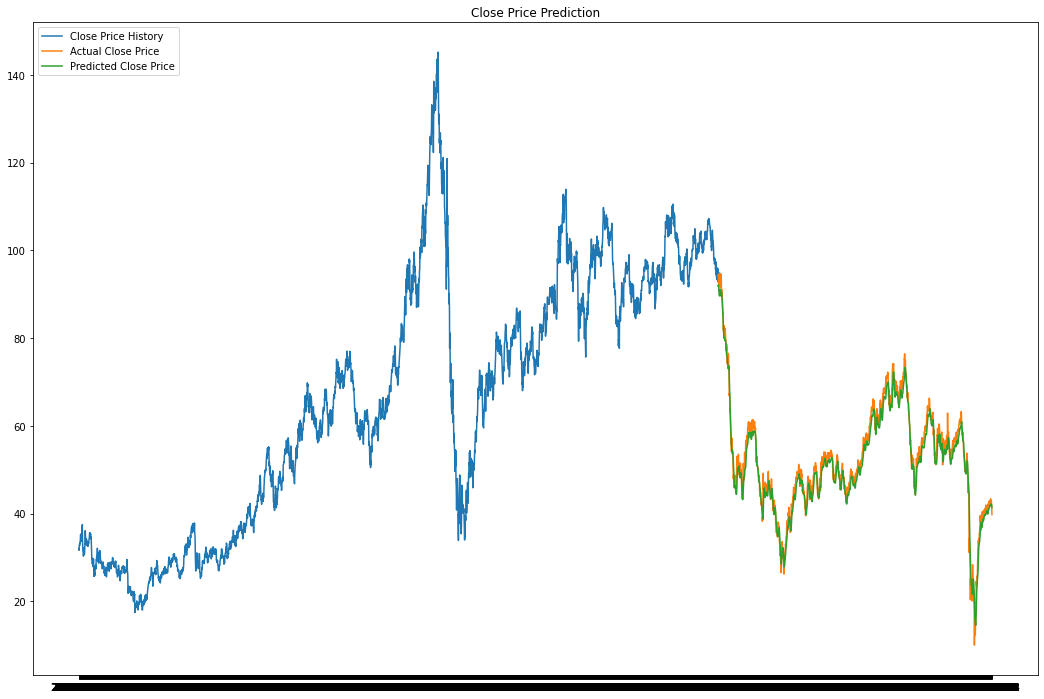

In [189]:
fig, ax = plt.subplots(figsize=(18,12))
plt.plot(train_data["Close"], label='Close Price History')
plt.plot(valid_data['Close'], label='Actual Close Price')
plt.plot(valid_data["Predictions"], label='Predicted Close Price')
plt.legend(loc='upper left')
plt.title("Close Price Prediction")

### Testing Predictions using LSTM

In [190]:
try_data = scaler.transform(new_dataset[5000:].values.reshape(-1,1))

In [191]:
X_try=[]
for i in range(90,try_data.shape[0]):
    X_try.append(try_data[i-90:i,0])
X_try=np.array(X_try)

In [192]:
X_try = np.reshape(X_try, (X_try.shape[0], X_try.shape[1], 1))
predicted_try = lstm_model.predict(X_try)
predicted_try = scaler.inverse_transform(predicted_try)

In [193]:
predicted_data = pd.DataFrame()

In [194]:
predicted_data['Pred_Vals'] = predicted_try.reshape(1, -1)[0]

In [195]:
try_real_data = pd.DataFrame(test_data)[1][-119:].values

In [196]:
predicted_data['Real_vals'] = try_real_data

In [197]:
predicted_data = predicted_data.set_index(new_dataset[5000+90:].index)

In [198]:
predicted_data

,Pred_Vals,Real_vals
Date,,
2021.01.20,51.930790,53.24
2021.01.21,51.939289,53.13
2021.01.22,51.914959,52.27
2021.01.25,51.708622,52.77
2021.01.26,51.559357,52.61
...,...,...
2021.07.02,71.817177,75.16
2021.07.06,72.290993,73.37
2021.07.07,72.310371,72.2


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

Text(0.5, 1.0, 'Close Price Prediction')

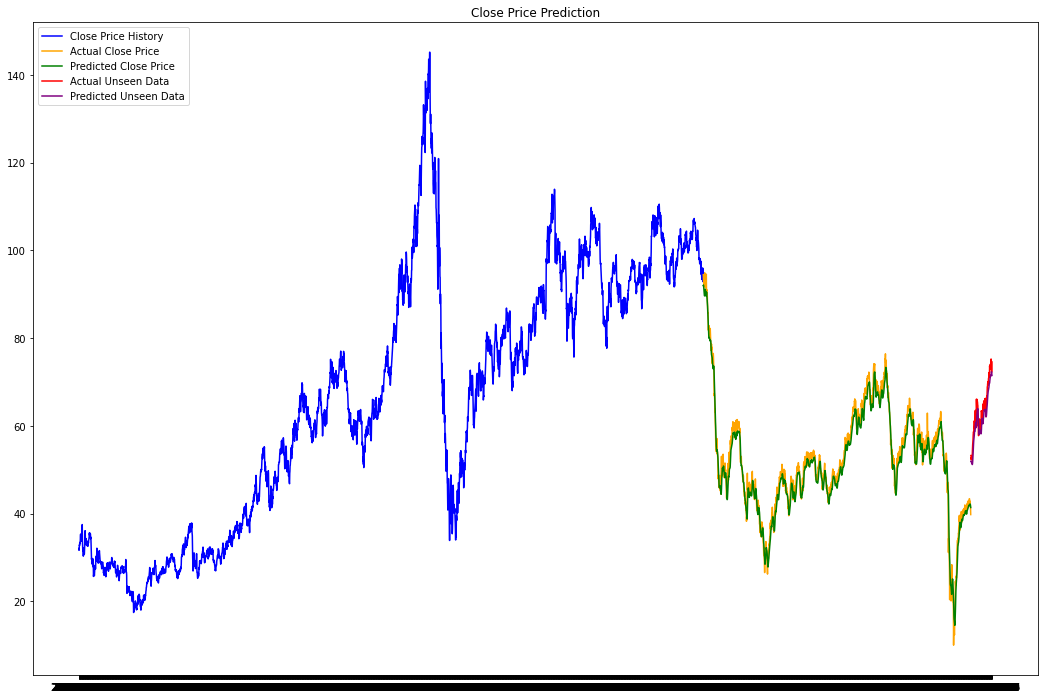

In [199]:
fig, ax = plt.subplots(figsize=(18,12))
plt.plot(train_data["Close"], label='Close Price History', c='blue')
plt.plot(valid_data['Close'], label='Actual Close Price', c='orange')
plt.plot(valid_data["Predictions"], label='Predicted Close Price', c='green')
plt.plot(predicted_data["Real_vals"], label='Actual Unseen Data', c='red')
plt.plot(predicted_data["Pred_Vals"], label='Predicted Unseen Data', c='purple')
plt.legend(loc='upper left')
plt.title("Close Price Prediction")

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'Unseen Close Price Prediction')

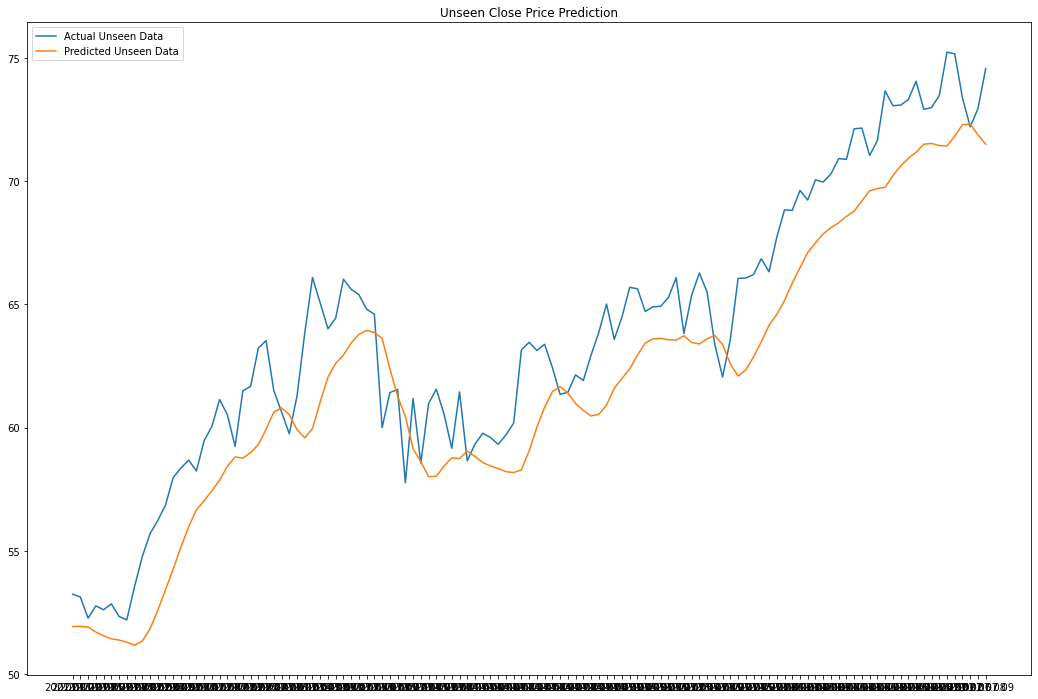

In [200]:
plt.plot(predicted_data["Real_vals"], label='Actual Unseen Data')
plt.plot(predicted_data["Pred_Vals"], label='Predicted Unseen Data')
plt.legend(loc='upper left')
plt.title("Unseen Close Price Prediction")

## Predicting Future Data using Prophet

### Creating Required DataFrame

In [201]:
test_dataset=pd.DataFrame(index=range(0,len(df)),columns=['ds','y'])
for i in range(0,len(df_data)):
    test_dataset["ds"][i]=dates[i]
    test_dataset["y"][i]=df_data["Close"][i]
print(test_dataset)

              ds      y
0     2000.08.23  32.05
1     2000.08.24  31.63
2     2000.08.25  32.05
3     2000.08.28  32.87
4     2000.08.29  32.72
...          ...    ...
5204  2021.07.02  75.16
5205  2021.07.06  73.37
5206  2021.07.07   72.2
5207  2021.07.08  72.94
5208  2021.07.09  74.56

[5209 rows x 2 columns]


### Predicting using fbprophet

In [202]:
m = Prophet()
m.fit(test_dataset)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [203]:
future = m.make_future_dataframe(periods=365, include_history=True)

In [204]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2000-08-23,33.103370,21.440284,45.170485
1,2000-08-24,33.063071,20.882952,44.993938
2,2000-08-25,33.025532,21.612341,44.647151
3,2000-08-28,33.008897,20.754948,45.725386
4,2000-08-29,32.940242,20.945084,44.989193
...,...,...,...,...
5569,2022-07-05,54.182890,36.857765,70.730557
5570,2022-07-06,54.225755,36.012423,70.464156
5571,2022-07-07,54.167462,36.796484,71.884455
5572,2022-07-08,54.103627,36.930068,70.543437


### Plotting Prediction using fbprophet

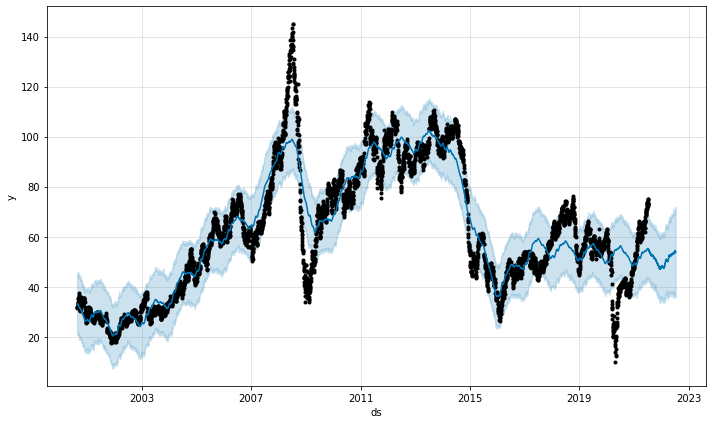

In [205]:
fig1 = m.plot(forecast)

# Model-2 (Polynomial Regression, fbProphet, Quarterly Returns)

## Import Libraries

In [206]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
from scipy.stats import kstest
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.pipeline import Pipeline
from matplotlib.pylab import rcParams
from fastai.tabular import add_datepart
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

rcParams['figure.figsize'] = 18, 12

## Import Crude Oil Dataset

In [207]:
data = pd.read_csv("Crude_All.csv")
df = data.copy()

## EDA

In [208]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [209]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

### Feature Engineering

In [210]:
add_datepart(df, 'Date', drop=False)
df.drop('Elapsed', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [211]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.asfreq('D')

### Cleaning Data

In [212]:
df = df.dropna(axis=0)

In [213]:
df = df[~(df['Close'] <= 0)]

### Plotting

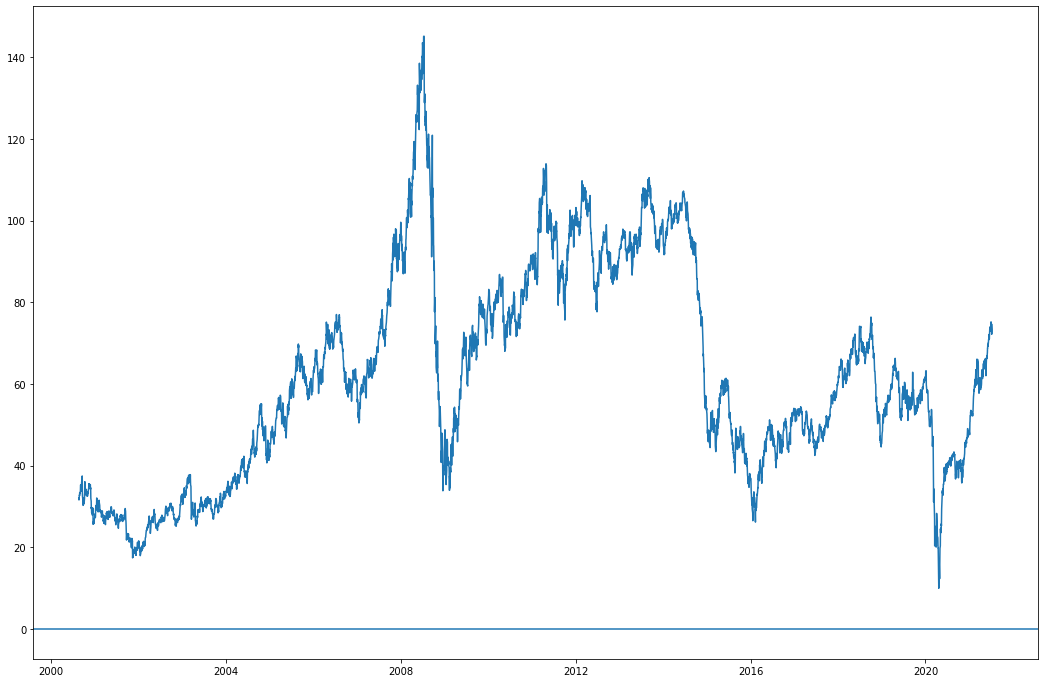

In [214]:
plt.plot(df.Close)
plt.axhline(y=0)

In [215]:
df.head(10)

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
Date,,,,,,,,,,,,,
2000-08-23,32.049999,2000.0,8.0,34.0,23.0,2.0,236.0,False,False,False,False,False,False
2000-08-24,31.629999,2000.0,8.0,34.0,24.0,3.0,237.0,False,False,False,False,False,False
2000-08-25,32.049999,2000.0,8.0,34.0,25.0,4.0,238.0,False,False,False,False,False,False
2000-08-28,32.869999,2000.0,8.0,35.0,28.0,0.0,241.0,False,False,False,False,False,False
2000-08-29,32.720001,2000.0,8.0,35.0,29.0,1.0,242.0,False,False,False,False,False,False
2000-08-30,33.400002,2000.0,8.0,35.0,30.0,2.0,243.0,False,False,False,False,False,False
2000-08-31,33.099998,2000.0,8.0,35.0,31.0,3.0,244.0,True,False,False,False,False,False
2000-09-01,33.380001,2000.0,9.0,35.0,1.0,4.0,245.0,False,True,False,False,False,False
2000-09-05,33.799999,2000.0,9.0,36.0,5.0,1.0,249.0,False,False,False,False,False,False


In [216]:
df.columns

Index(['Close', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start'],
      dtype='object')

## Monthly Data

In [217]:
index = pd.date_range("2000-08-31", periods=252, freq="M")
monthly_df = pd.DataFrame(index=index, columns=['AvgClose', 'Year', 'Month'])
monthly_df.AvgClose = df.Close.resample('M').mean()
monthly_df.Year = monthly_df.index.year
monthly_df.Month = monthly_df.index.month
monthly_df['MChange'] = monthly_df.AvgClose.pct_change()
monthly_df

,AvgClose,Year,Month,MChange
2000-08-31,32.545714,2000,8,NaN
2000-09-30,33.871000,2000,9,0.040721
2000-10-31,32.973182,2000,10,-0.026507
2000-11-30,34.264500,2000,11,0.039163
2000-12-31,28.355000,2000,12,-0.172467
...,...,...,...,...
2021-03-31,62.357391,2021,3,0.055812
2021-04-30,61.703810,2021,4,-0.010481
2021-05-31,65.157000,2021,5,0.055964
2021-06-30,71.352729,2021,6,0.095089


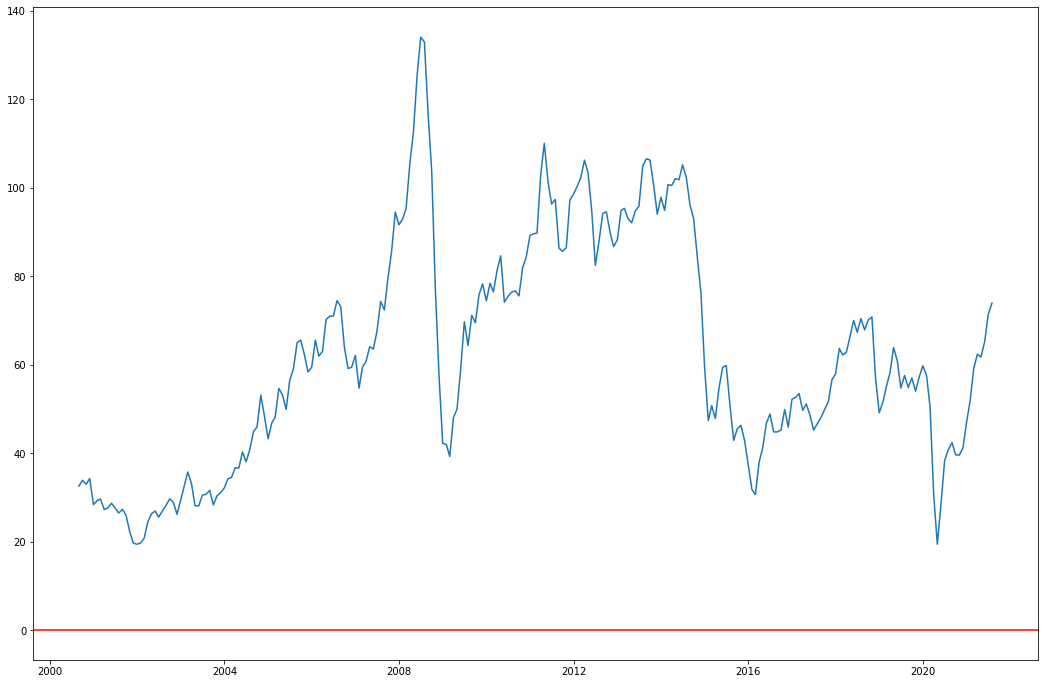

In [218]:
plt.plot(monthly_df.AvgClose)
plt.axhline(y=0, c='r')

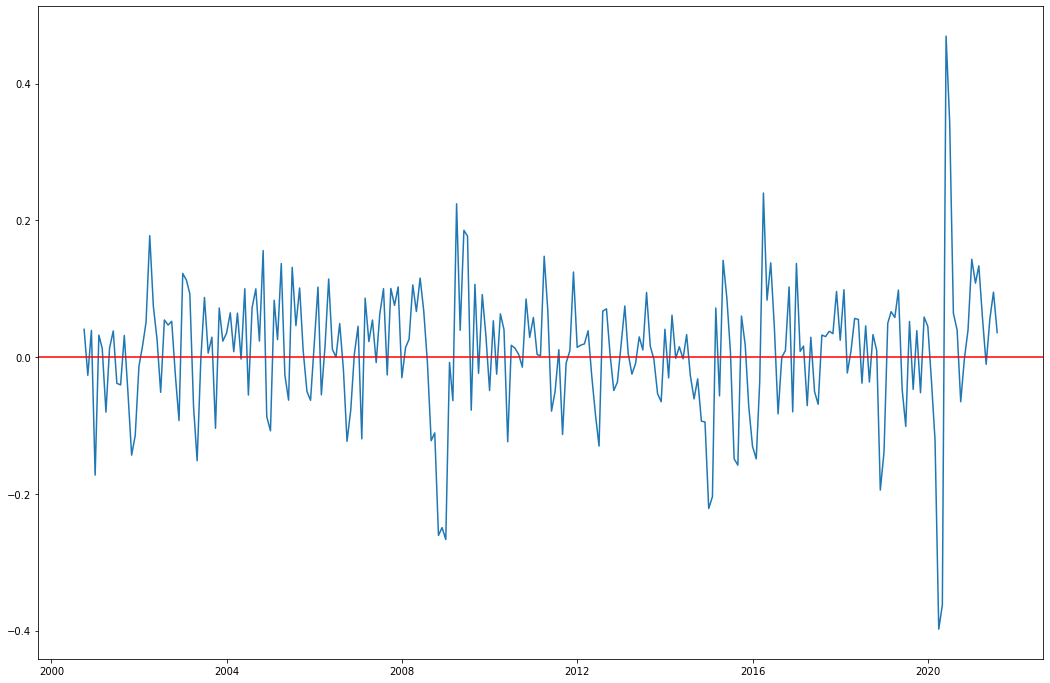

In [219]:
plt.plot(monthly_df.AvgClose.pct_change())
plt.axhline(y=0, c='r')

## Quaterly_data

In [220]:
index = pd.date_range("2000-08-31", periods=85, freq="Q")
quaterly_df = pd.DataFrame(index=index, columns=['QAvgClose', 'Year', 'Month'])
quaterly_df.QAvgClose = df.Close.resample('Q').mean()
quaterly_df.Year = quaterly_df.index.year
quaterly_df.Month = quaterly_df.index.month
quaterly_df['QChange'] = quaterly_df.QAvgClose.pct_change()
quaterly_df

,QAvgClose,Year,Month,QChange
2000-09-30,33.527407,2000,9,NaN
2000-12-31,31.900000,2000,12,-0.048540
2001-03-31,28.671452,2001,3,-0.101208
2001-06-30,27.982381,2001,6,-0.024033
2001-09-30,26.644500,2001,9,-0.047812
...,...,...,...,...
2020-09-30,40.924062,2020,9,0.408230
2020-12-31,42.562419,2020,12,0.040034
2021-03-31,58.136394,2021,3,0.365909
2021-06-30,66.169524,2021,6,0.138177


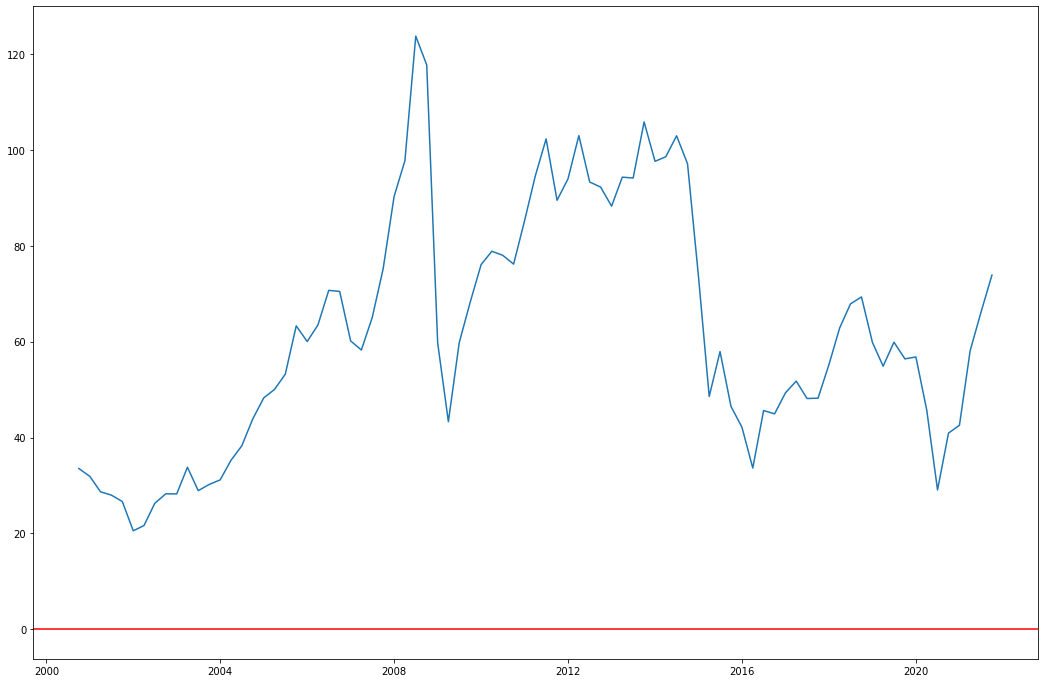

In [221]:
plt.plot(quaterly_df.QAvgClose)
plt.axhline(y=0, c='r')

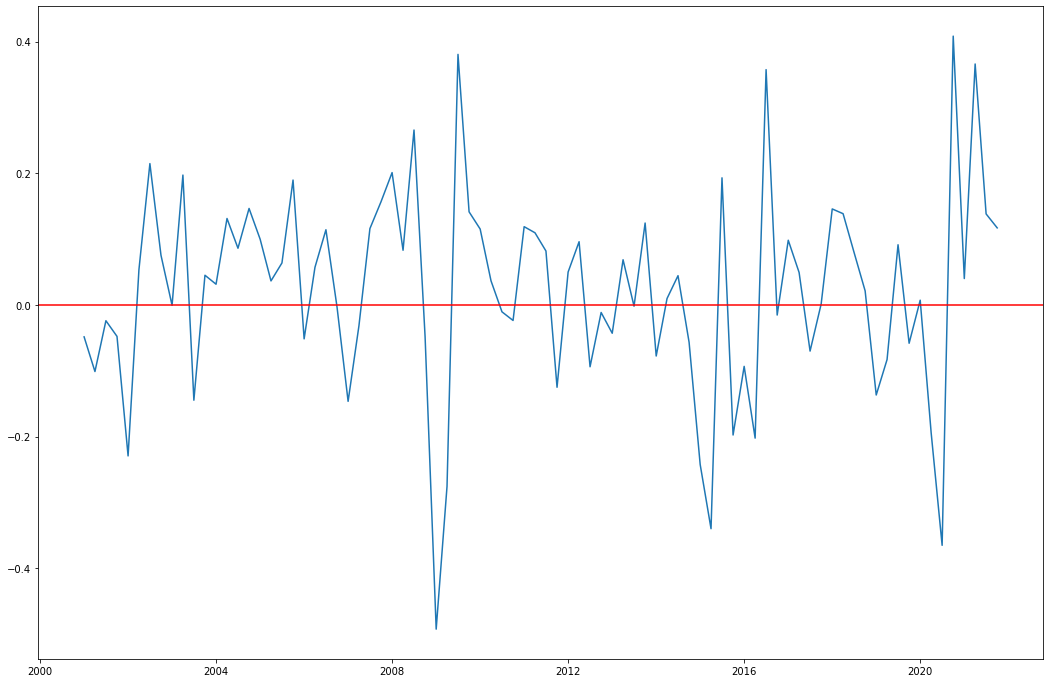

In [222]:
plt.plot(quaterly_df.QAvgClose.pct_change())
plt.axhline(y=0, c='r')

## GDP Data

In [223]:
gdp_data = pd.read_csv("GDP.csv")
gdp = gdp_data.copy()

In [224]:
gdp['DATE'] = pd.to_datetime(gdp['DATE'])
gdp = gdp.set_index('DATE')
gdp = gdp.asfreq('D')
gdp = gdp.resample('Q').mean()

In [225]:
gdp['Month'] = gdp.index.month
gdp['Year'] = gdp.index.year
gdp

,GDP,Month,Year
DATE,,,
2000-09-30,10318.165,9,2000
2000-12-31,10435.744,12,2000
2001-03-31,10470.231,3,2001
2001-06-30,10599.000,6,2001
2001-09-30,10598.020,9,2001
...,...,...,...
2020-06-30,19477.444,6,2020
2020-09-30,21138.574,9,2020
2020-12-31,21477.597,12,2020


In [226]:
gdp.GDP.pct_change()

DATE
2000-09-30         NaN
2000-12-31    0.011395
2001-03-31    0.003305
2001-06-30    0.012299
2001-09-30   -0.000092
                ...   
2020-06-30   -0.093287
2020-09-30    0.085285
2020-12-31    0.016038
2021-03-31    0.026103
2021-06-30    0.031053
Freq: Q-DEC, Name: GDP, Length: 84, dtype: float64

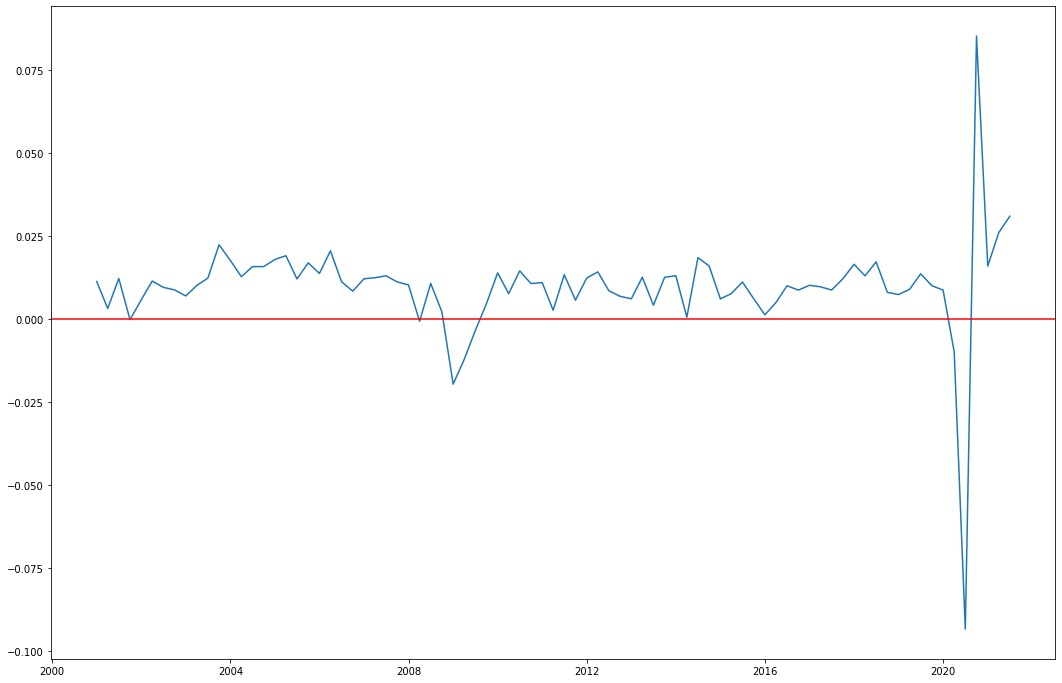

In [227]:
plt.plot(gdp.GDP.pct_change())
plt.axhline(y=0, c='r')

In [228]:
quarterly_df = quaterly_df.join(gdp.GDP.pct_change())[:-1]
quarterly_df

,QAvgClose,Year,Month,QChange,GDP
2000-09-30,33.527407,2000,9,NaN,NaN
2000-12-31,31.900000,2000,12,-0.048540,0.011395
2001-03-31,28.671452,2001,3,-0.101208,0.003305
2001-06-30,27.982381,2001,6,-0.024033,0.012299
2001-09-30,26.644500,2001,9,-0.047812,-0.000092
...,...,...,...,...,...
2020-06-30,29.060645,2020,6,-0.365175,-0.093287
2020-09-30,40.924062,2020,9,0.408230,0.085285
2020-12-31,42.562419,2020,12,0.040034,0.016038
2021-03-31,58.136394,2021,3,0.365909,0.026103


## Fitting Polynomial Regression

In [229]:
quarterly_df

,QAvgClose,Year,Month,QChange,GDP
2000-09-30,33.527407,2000,9,NaN,NaN
2000-12-31,31.900000,2000,12,-0.048540,0.011395
2001-03-31,28.671452,2001,3,-0.101208,0.003305
2001-06-30,27.982381,2001,6,-0.024033,0.012299
2001-09-30,26.644500,2001,9,-0.047812,-0.000092
...,...,...,...,...,...
2020-06-30,29.060645,2020,6,-0.365175,-0.093287
2020-09-30,40.924062,2020,9,0.408230,0.085285
2020-12-31,42.562419,2020,12,0.040034,0.016038
2021-03-31,58.136394,2021,3,0.365909,0.026103


In [230]:
x = quarterly_df[['Year', 'Month', 'GDP']][1:].values
x

array([[ 2.000000e+03,  1.200000e+01,  1.139534e-02],
       [ 2.001000e+03,  3.000000e+00,  3.304700e-03],
       [ 2.001000e+03,  6.000000e+00,  1.229858e-02],
       [ 2.001000e+03,  9.000000e+00, -9.246155e-05],
       ...,
       [ 2.020000e+03,  9.000000e+00,  8.528480e-02],
       [ 2.020000e+03,  1.200000e+01,  1.603812e-02],
       [ 2.021000e+03,  3.000000e+00,  2.610297e-02],
       [ 2.021000e+03,  6.000000e+00,  3.105309e-02]])

In [231]:
y = quarterly_df[['QChange']][1:].values
y

array([[-0.04854 ],
       [-0.101208],
       [-0.024033],
       [-0.047812],
       ...,
       [ 0.40823 ],
       [ 0.040034],
       [ 0.365909],
       [ 0.138177]])

In [232]:
Input=[('polynomial',PolynomialFeatures(degree=10)),('modal',LinearRegression())]
pipe=Pipeline(Input)
pipe.fit(x[:-3],y[:-3])

Pipeline(memory=None,
         steps=[('polynomial',
                 PolynomialFeatures(degree=10, include_bias=True,
                                    interaction_only=False, order='C')),
                ('modal',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [233]:
poly_pred=pipe.predict(x[:-3])

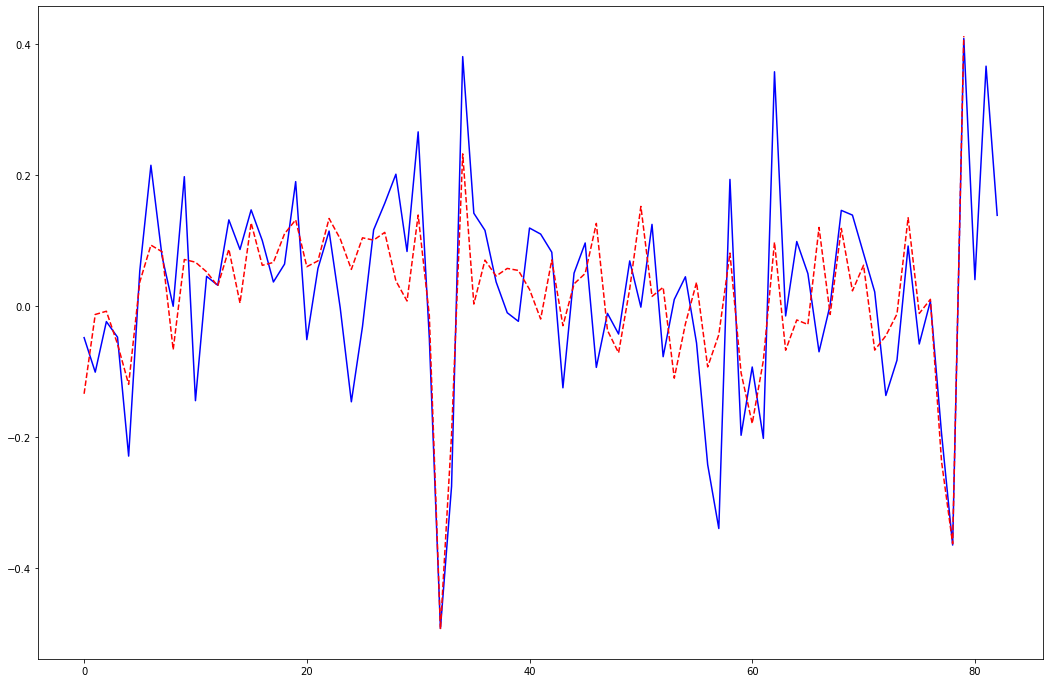

In [234]:
plt.plot(y, c='b')
plt.plot(poly_pred, c='r', ls='--')

In [235]:
pred = pipe.predict(x[-3:])
actual = y[-3:]
pred_df = pd.DataFrame()
pred_df["Predictions"] = pred.reshape(1,-1)[0]
pred_df["Actual Values"] = actual.reshape(1,-1)[0]
pred_df

,Predictions,Actual Values
0,0.218066,0.040034
1,0.349878,0.365909
2,0.083387,0.138177


## Prediction using Prophet

In [236]:
pro_df = pd.DataFrame()
pro_df['ds'] = quarterly_df.index
pro_df['y'] = quarterly_df.QChange.values

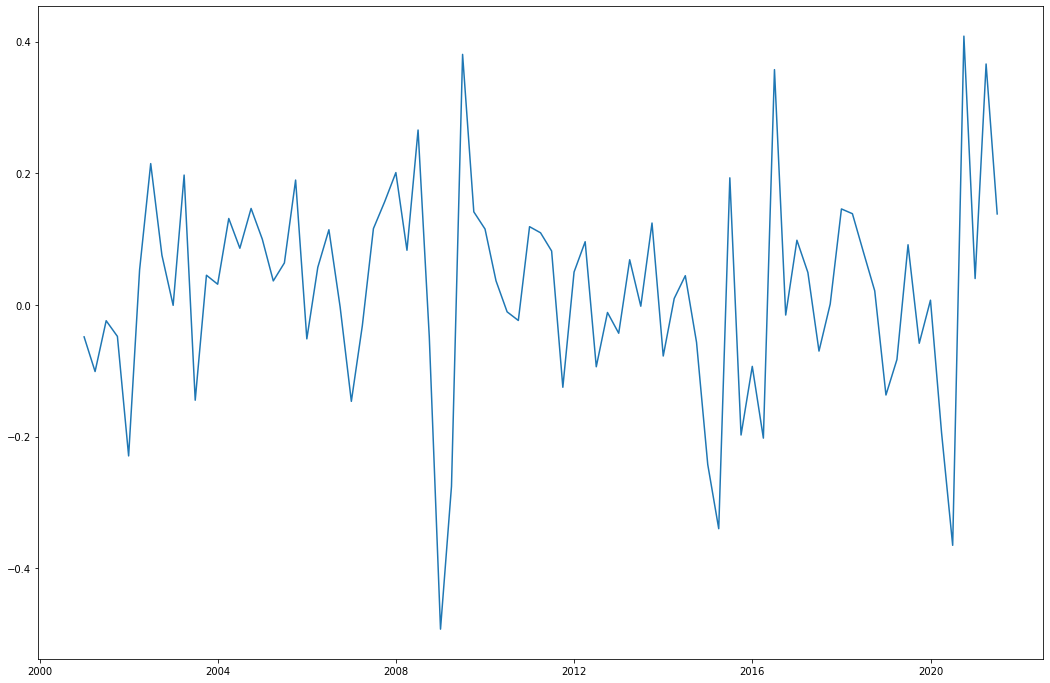

In [237]:
plt.plot(pro_df.set_index(['ds']))

In [238]:
data_train, data_test = pro_df.iloc[:70,:].copy(), pro_df.iloc[70:,:]

In [239]:
data_train.shape, data_test.shape

((70, 2), (14, 2))

In [240]:
model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)

In [241]:
model.fit(data_train)

In [242]:
future = model.make_future_dataframe(periods=18, freq='Q')
forecast = model.predict(future)

In [243]:
test = model.predict(data_test)

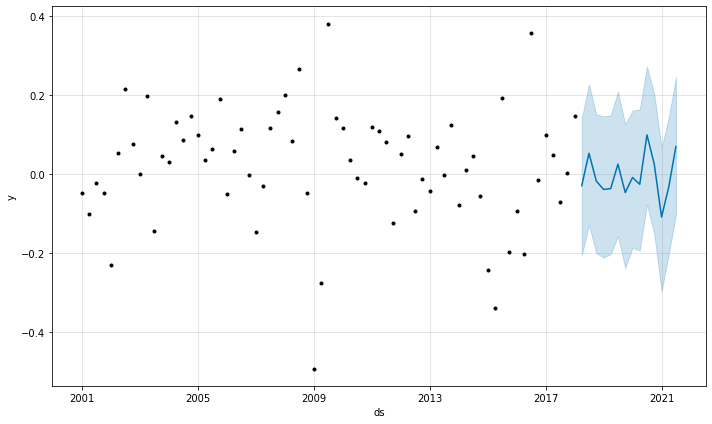

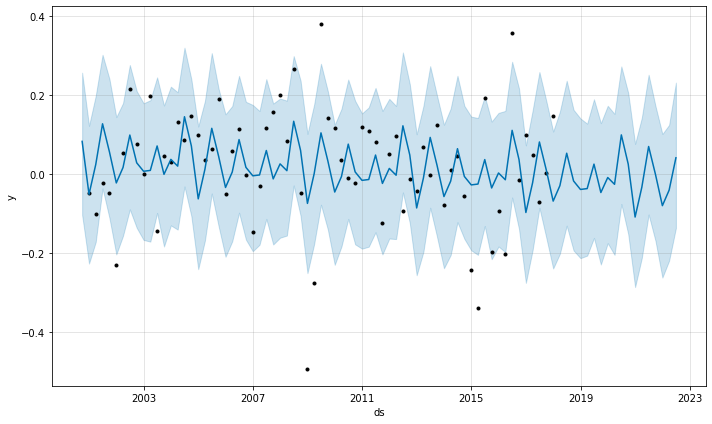

In [244]:
fig = model.plot(test)
fig = model.plot(forecast)

# Model-3 (Decision Tree, XGBoost, Quarterly and Monthly Returns)

## Import Libraries

In [245]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
from scipy.stats import kstest
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from keras.models import Sequential
from sklearn.pipeline import Pipeline
from matplotlib.pylab import rcParams
from fastai.tabular import add_datepart
from keras.layers import LSTM, Dropout, Dense
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

rcParams['figure.figsize'] = 18, 12

## Import Crude Oil Dataset

In [246]:
data = pd.read_csv("Crude_All.csv")
df = data.copy()

## EDA

In [247]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [248]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

### Feature Engineering

In [249]:
add_datepart(df, 'Date', drop=False)
df.drop('Elapsed', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [250]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.asfreq('D')

### Cleaning Data

In [251]:
df = df.dropna(axis=0)

In [252]:
df = df[~(df['Close'] <= 0)]

### Plotting

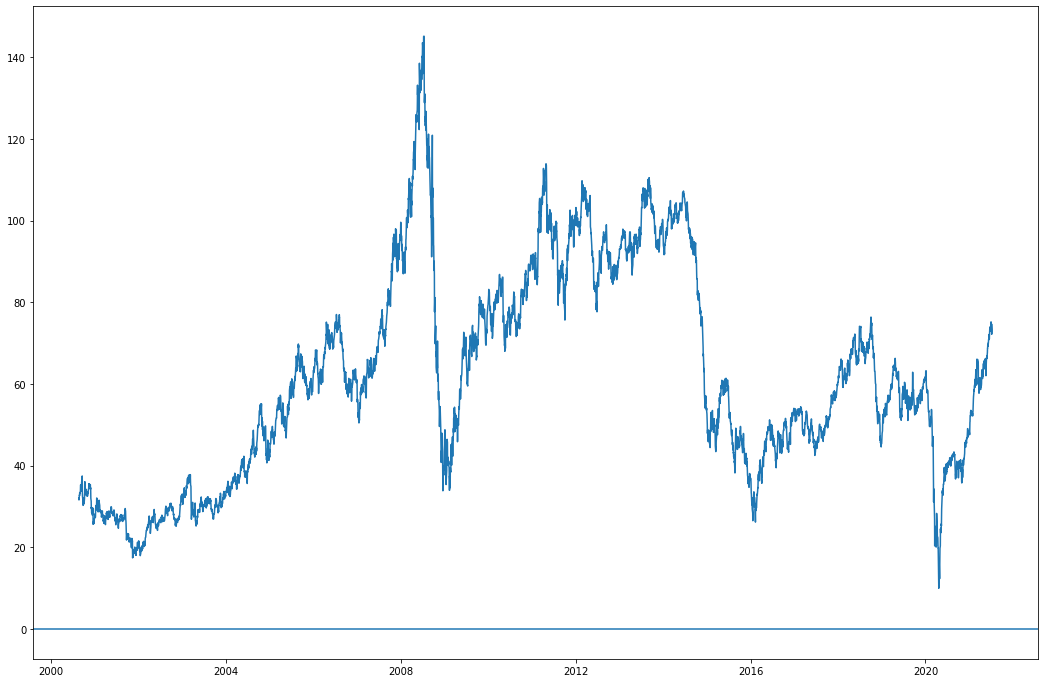

In [253]:
plt.plot(df.Close)
plt.axhline(y=0)

In [254]:
df.head(10)

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
Date,,,,,,,,,,,,,
2000-08-23,32.049999,2000.0,8.0,34.0,23.0,2.0,236.0,False,False,False,False,False,False
2000-08-24,31.629999,2000.0,8.0,34.0,24.0,3.0,237.0,False,False,False,False,False,False
2000-08-25,32.049999,2000.0,8.0,34.0,25.0,4.0,238.0,False,False,False,False,False,False
2000-08-28,32.869999,2000.0,8.0,35.0,28.0,0.0,241.0,False,False,False,False,False,False
2000-08-29,32.720001,2000.0,8.0,35.0,29.0,1.0,242.0,False,False,False,False,False,False
2000-08-30,33.400002,2000.0,8.0,35.0,30.0,2.0,243.0,False,False,False,False,False,False
2000-08-31,33.099998,2000.0,8.0,35.0,31.0,3.0,244.0,True,False,False,False,False,False
2000-09-01,33.380001,2000.0,9.0,35.0,1.0,4.0,245.0,False,True,False,False,False,False
2000-09-05,33.799999,2000.0,9.0,36.0,5.0,1.0,249.0,False,False,False,False,False,False


In [255]:
df.columns

Index(['Close', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start'],
      dtype='object')

## Monthly Data

In [256]:
index = pd.date_range("2000-08-31", periods=252, freq="M")
monthly_df = pd.DataFrame(index=index, columns=['AvgClose', 'Year', 'Month'])
monthly_df.AvgClose = df.Close.resample('M').mean()
monthly_df.Year = monthly_df.index.year
monthly_df.Month = monthly_df.index.month
monthly_df['MChange'] = monthly_df.AvgClose.pct_change()
monthly_df

,AvgClose,Year,Month,MChange
2000-08-31,32.545714,2000,8,NaN
2000-09-30,33.871000,2000,9,0.040721
2000-10-31,32.973182,2000,10,-0.026507
2000-11-30,34.264500,2000,11,0.039163
2000-12-31,28.355000,2000,12,-0.172467
...,...,...,...,...
2021-03-31,62.357391,2021,3,0.055812
2021-04-30,61.703810,2021,4,-0.010481
2021-05-31,65.157000,2021,5,0.055964
2021-06-30,71.352729,2021,6,0.095089


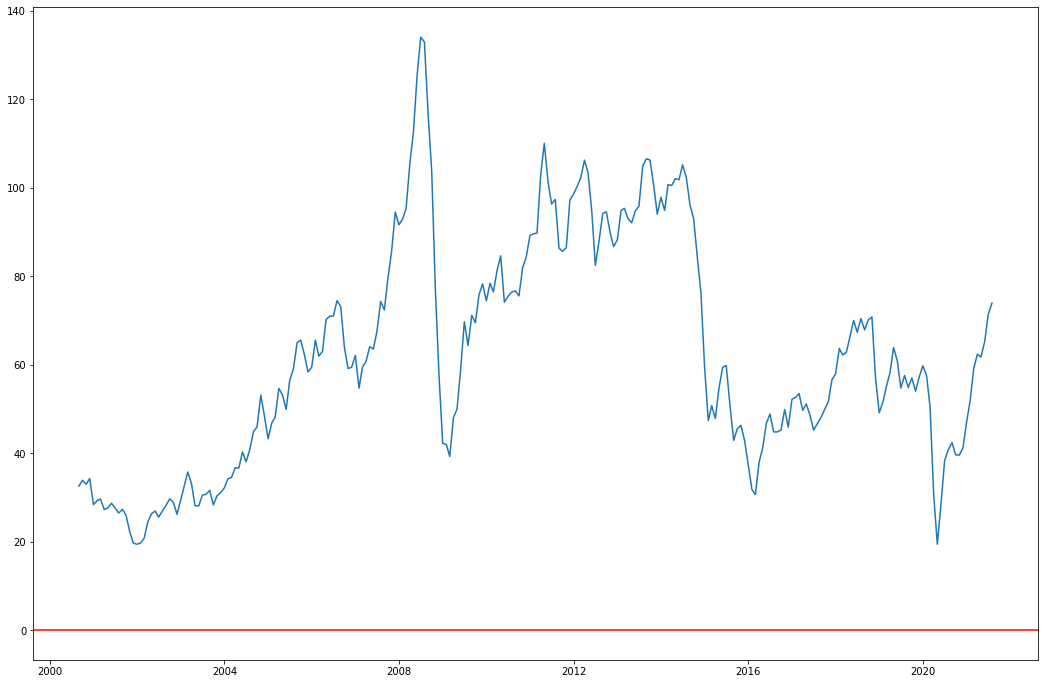

In [257]:
plt.plot(monthly_df.AvgClose)
plt.axhline(y=0, c='r')

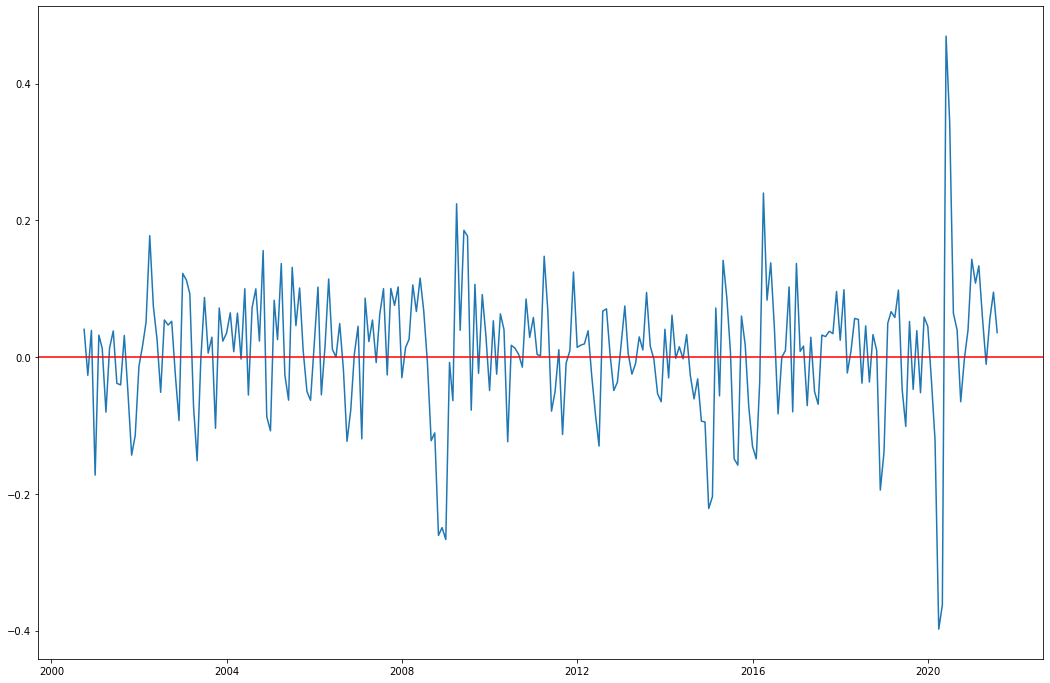

In [258]:
plt.plot(monthly_df.AvgClose.pct_change())
plt.axhline(y=0, c='r')

## Quaterly_data

In [259]:
index = pd.date_range("2000-08-31", periods=85, freq="Q")
quaterly_df = pd.DataFrame(index=index, columns=['QAvgClose', 'Year', 'Month'])
quaterly_df.QAvgClose = df.Close.resample('Q').mean()
quaterly_df.Year = quaterly_df.index.year
quaterly_df.Month = quaterly_df.index.month
quaterly_df['QChange'] = quaterly_df.QAvgClose.pct_change()
quaterly_df

,QAvgClose,Year,Month,QChange
2000-09-30,33.527407,2000,9,NaN
2000-12-31,31.900000,2000,12,-0.048540
2001-03-31,28.671452,2001,3,-0.101208
2001-06-30,27.982381,2001,6,-0.024033
2001-09-30,26.644500,2001,9,-0.047812
...,...,...,...,...
2020-09-30,40.924062,2020,9,0.408230
2020-12-31,42.562419,2020,12,0.040034
2021-03-31,58.136394,2021,3,0.365909
2021-06-30,66.169524,2021,6,0.138177


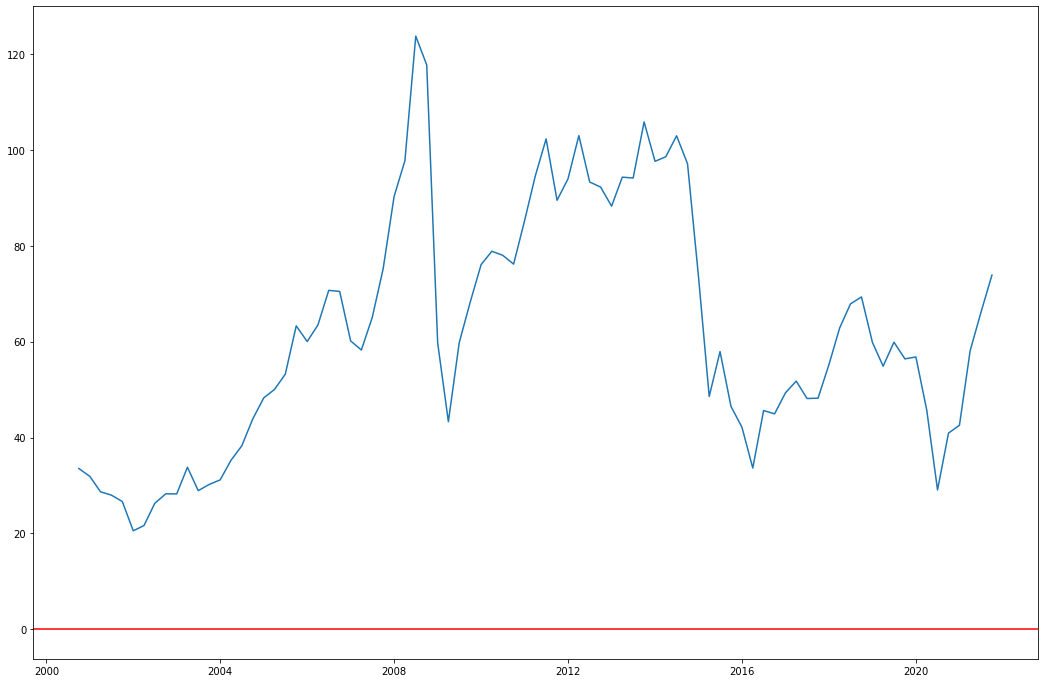

In [260]:
plt.plot(quaterly_df.QAvgClose)
plt.axhline(y=0, c='r')

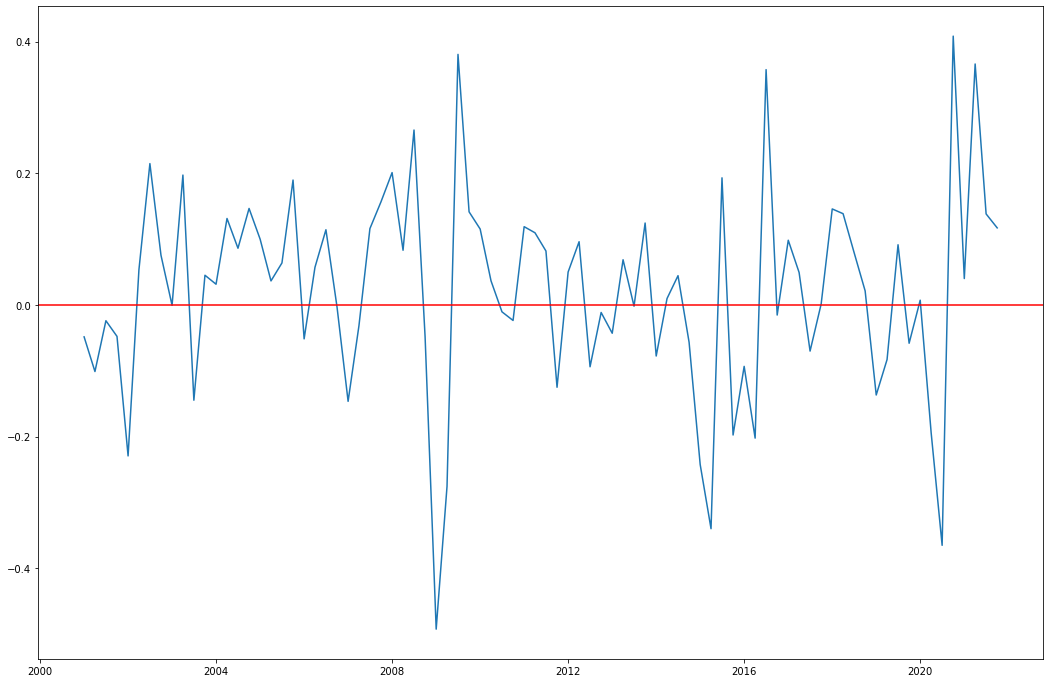

In [261]:
plt.plot(quaterly_df.QAvgClose.pct_change())
plt.axhline(y=0, c='r')

## GDP Data

In [262]:
gdp_data = pd.read_csv("GDP.csv")
gdp = gdp_data.copy()

In [263]:
gdp['DATE'] = pd.to_datetime(gdp['DATE'])
gdp = gdp.set_index('DATE')
gdp = gdp.asfreq('D')
gdp = gdp.resample('Q').mean()

In [264]:
gdp['Month'] = gdp.index.month
gdp['Year'] = gdp.index.year
gdp

,GDP,Month,Year
DATE,,,
2000-09-30,10318.165,9,2000
2000-12-31,10435.744,12,2000
2001-03-31,10470.231,3,2001
2001-06-30,10599.000,6,2001
2001-09-30,10598.020,9,2001
...,...,...,...
2020-06-30,19477.444,6,2020
2020-09-30,21138.574,9,2020
2020-12-31,21477.597,12,2020


In [265]:
gdp.GDP.pct_change()

DATE
2000-09-30         NaN
2000-12-31    0.011395
2001-03-31    0.003305
2001-06-30    0.012299
2001-09-30   -0.000092
                ...   
2020-06-30   -0.093287
2020-09-30    0.085285
2020-12-31    0.016038
2021-03-31    0.026103
2021-06-30    0.031053
Freq: Q-DEC, Name: GDP, Length: 84, dtype: float64

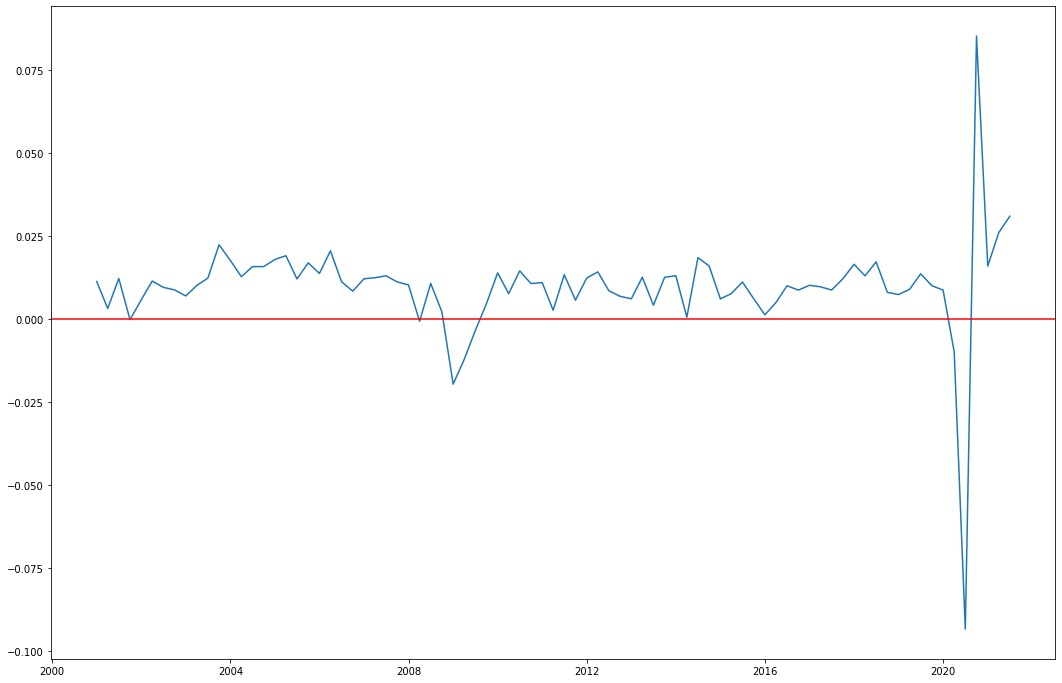

In [266]:
plt.plot(gdp.GDP.pct_change())
plt.axhline(y=0, c='r')

In [267]:
quarterly_df = quaterly_df.join(gdp.GDP.pct_change())[:-1]
quarterly_df

,QAvgClose,Year,Month,QChange,GDP
2000-09-30,33.527407,2000,9,NaN,NaN
2000-12-31,31.900000,2000,12,-0.048540,0.011395
2001-03-31,28.671452,2001,3,-0.101208,0.003305
2001-06-30,27.982381,2001,6,-0.024033,0.012299
2001-09-30,26.644500,2001,9,-0.047812,-0.000092
...,...,...,...,...,...
2020-06-30,29.060645,2020,6,-0.365175,-0.093287
2020-09-30,40.924062,2020,9,0.408230,0.085285
2020-12-31,42.562419,2020,12,0.040034,0.016038
2021-03-31,58.136394,2021,3,0.365909,0.026103


## Modeling

### Quaterly Predictions

In [268]:
quarterly_df

,QAvgClose,Year,Month,QChange,GDP
2000-09-30,33.527407,2000,9,NaN,NaN
2000-12-31,31.900000,2000,12,-0.048540,0.011395
2001-03-31,28.671452,2001,3,-0.101208,0.003305
2001-06-30,27.982381,2001,6,-0.024033,0.012299
2001-09-30,26.644500,2001,9,-0.047812,-0.000092
...,...,...,...,...,...
2020-06-30,29.060645,2020,6,-0.365175,-0.093287
2020-09-30,40.924062,2020,9,0.408230,0.085285
2020-12-31,42.562419,2020,12,0.040034,0.016038
2021-03-31,58.136394,2021,3,0.365909,0.026103


#### Using Decision Tree

In [269]:
quarterly_df[["Year", "Month", "GDP"]][1:-1].values

array([[ 2.000000e+03,  1.200000e+01,  1.139534e-02],
       [ 2.001000e+03,  3.000000e+00,  3.304700e-03],
       [ 2.001000e+03,  6.000000e+00,  1.229858e-02],
       [ 2.001000e+03,  9.000000e+00, -9.246155e-05],
       ...,
       [ 2.020000e+03,  6.000000e+00, -9.328657e-02],
       [ 2.020000e+03,  9.000000e+00,  8.528480e-02],
       [ 2.020000e+03,  1.200000e+01,  1.603812e-02],
       [ 2.021000e+03,  3.000000e+00,  2.610297e-02]])

In [270]:
quarterly_df["QAvgClose"][1:-3].values

array([31.9     , 28.671452, 27.982381, 26.6445  , ..., 56.825   , 45.77742 , 29.060645, 40.924062])

In [271]:
dtree = DecisionTreeRegressor()

In [272]:
dtree.fit(quarterly_df[["Year", "Month", "GDP"]][1:-3].values, quarterly_df["QAvgClose"][1:-3].values)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [273]:
dtree.predict(quarterly_df[["Year", "Month", "GDP"]][-3:].values)

array([40.924062, 40.924062, 40.924062])

In [274]:
quarterly_df["QAvgClose"][-3:].values

array([42.562419, 58.136394, 66.169524])

#### Using XGBoost

In [275]:
xgbtree = XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=100, subsample=0.4)

In [276]:
xgbtree.fit(quarterly_df[["Year", "Month", "GDP"]][1:-3].values, quarterly_df["QAvgClose"][1:-3].values)

[22:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.4, verbosity=1)

In [277]:
xgbtree.predict(quarterly_df[["Year", "Month", "GDP"]][-3:].values)

array([46.00236 , 48.049244, 46.90049 ], dtype=float32)

In [278]:
quarterly_df["QAvgClose"][-3:].values

array([42.562419, 58.136394, 66.169524])

### Monthly Predictions

In [279]:
monthly_df.join(gdp['GDP']).bfill()

,AvgClose,Year,Month,MChange,GDP
2000-08-31,32.545714,2000,8,0.040721,10318.165
2000-09-30,33.871000,2000,9,0.040721,10318.165
2000-10-31,32.973182,2000,10,-0.026507,10435.744
2000-11-30,34.264500,2000,11,0.039163,10435.744
2000-12-31,28.355000,2000,12,-0.172467,10435.744
...,...,...,...,...,...
2021-03-31,62.357391,2021,3,0.055812,22038.226
2021-04-30,61.703810,2021,4,-0.010481,22722.581
2021-05-31,65.157000,2021,5,0.055964,22722.581
2021-06-30,71.352729,2021,6,0.095089,22722.581


#### Using XGBoost

In [280]:
xgbtree = XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=1000, subsample=0.8)

In [281]:
xgbtree.fit(monthly_df.join(gdp['GDP']).bfill()[["Year", "Month", "GDP"]][1:-4].values, monthly_df.join(gdp['GDP']).bfill()["MChange"][1:-4].values)

[22:02:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [282]:
xgbtree.predict(monthly_df.join(gdp['GDP']).bfill()[["Year", "Month", "GDP"]][-4:-1].values)

array([0.024292, 0.164408, 0.092916], dtype=float32)

In [283]:
monthly_df.join(gdp['GDP']).bfill()["MChange"][-4:-1].values

array([-0.010481,  0.055964,  0.095089])